<a href="https://colab.research.google.com/github/matthiasweidlich/conf_tutorial/blob/master/02_rules_replay_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-On Exercise 2: Rule Checking and Replay-based Conformance

In this exercise, you will take up the real-life event log of a Dutch financial institute, known already from the earlier notebook. Be reminded that you should be able to clone the repository containing the notebooks and the example data with the code in the next cell. If this does not work, however, you can also download the event log (XES format, please unzip) [here](http://www.win.tue.nl/bpi/doku.php?id=2012:challenge) and then either copy it to your google drive, mount it, and read it from there, or directly upload it using your browser.

Also, further details can be found in the [description of the dataset](http://www.win.tue.nl/bpi/doku.php?id=2012:challenge).

In [1]:
# basic configuration
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# import data from google drive
#from google.colab import drive
#drive.mount('/content/drive')

# direct data upload
#from google.colab import files
#files.upload()

# clone the repository that contains the notebooks and also the data file
!git clone https://github.com/matthiasweidlich/conf_tutorial.git
!pip install pmlab-lite 

     |████████████████████████████████| 51kB 3.2MB/s 


## Import Event Log

In [1]:
from pprint import pprint

log_file = '/content/conf_tutorial/financial_log.xes' # if not in colab or import from different folder: insert path here

Now import the given log and compute the trace variants of the log along with their frequencies.

In [2]:
from pmlab_lite.helper.io import xes

log = xes.import_xes(log_file)
print('Load log with %s traces.' len(log.traces))

100%|██████████| 13087/13087 [01:05<00:00, 200.23it/s]

Load log with 13087 traces.


In [3]:
trace_variants = {}
for trace in log.get_traces():
    events = []
    for event in trace:
        events.append(event['concept:name'])
    trace_variants[tuple(events)] = trace_variants.get(tuple(events), 0) + 1
    
# print the two most frequent variants
trace_variants_sorted_by_freq = sorted(trace_variants.items(), key=lambda kv: kv[1], reverse=True)
pprint(trace_variants_sorted_by_freq[:4])

[(('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED'), 3429),
 (('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'A_DECLINED',
   'W_Afhandelen leads'),
  1872),
 (('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'A_DECLINED',
   'W_Afhandelen leads'),
  271),
 (('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'A_PREACCEPTED',
   'W_Completeren aanvraag',
   'W_Afhandelen leads',
   'W_Completeren aanvraag',
   'A_DECLINED',
   'W_Completeren aanvraag'),
  209)]


## Import Process Model

For the log, a process model is given in the form of a Petri net. Such a process model is typically created manually. For this particular example, however, the model has been discovered automatically using the Inductive Miner, applying some noise filtering threshold. 

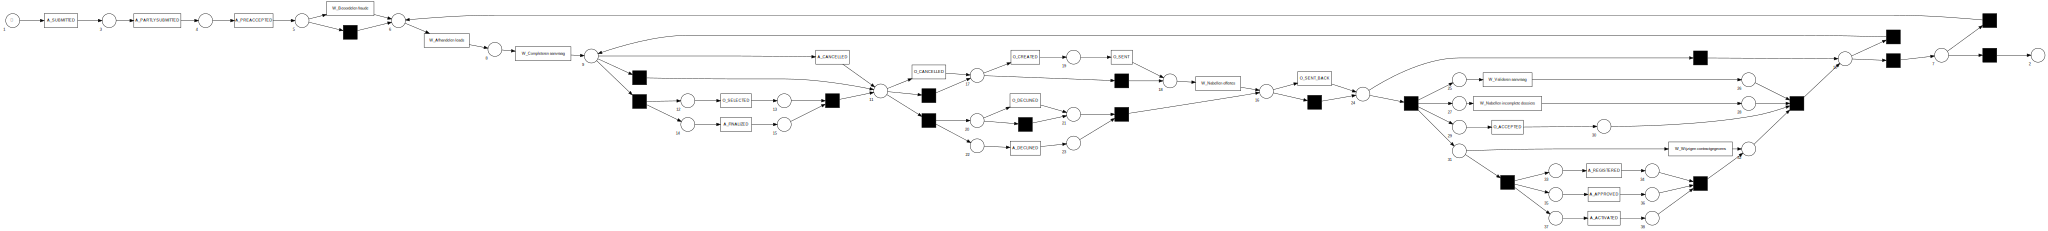

In [4]:
from pmlab_lite.pn import PetriNet 
from pmlab_lite.helper.io import pnml 
from pmlab_lite.helper.viz import dot 

net = PetriNet()
pnml.load(net, "/content/conf_tutorial/financial_log_80_noise.pnml") 

# mark the initial place
net.add_marking(1,1)
# visualise it 
dot.draw_petri_net(net) 

Set up some helper dictionaries to relate transition IDs (from the Petri net) and activity labels to each other. Observe that an activity label is only assigned to a single transition. However, multiple transitions may carry a _tau_ label, representing a silent transition.



In [5]:
mapping = net.get_mapping()
rev_mapping = net.rev_mapping()                         

# mapping from labels to LISTS of transitions ids
pprint(mapping)

# mapping from transitions id to label
pprint(rev_mapping)


{'A_ACTIVATED': [-37],
 'A_APPROVED': [-36],
 'A_CANCELLED': [-13],
 'A_DECLINED': [-24],
 'A_FINALIZED': [-12],
 'A_PARTLYSUBMITTED': [-2],
 'A_PREACCEPTED': [-3],
 'A_REGISTERED': [-35],
 'A_SUBMITTED': [-1],
 'O_ACCEPTED': [-32],
 'O_CANCELLED': [-15],
 'O_CREATED': [-17],
 'O_DECLINED': [-23],
 'O_SELECTED': [-11],
 'O_SENT': [-18],
 'O_SENT_BACK': [-26],
 'W_Afhandelen leads': [-6],
 'W_Beoordelen fraude': [-5],
 'W_Completeren aanvraag': [-7],
 'W_Nabellen incomplete dossiers': [-31],
 'W_Nabellen offertes': [-19],
 'W_Valideren aanvraag': [-30],
 'W_Wijzigen contractgegevens': [-38],
 'tau': [-4,
         -8,
         -9,
         -10,
         -14,
         -16,
         -20,
         -21,
         -22,
         -25,
         -27,
         -28,
         -29,
         -33,
         -34,
         -39,
         -40,
         -41,
         -42]}
{-42: 'tau',
 -41: 'tau',
 -40: 'tau',
 -39: 'tau',
 -38: 'W_Wijzigen contractgegevens',
 -37: 'A_ACTIVATED',
 -36: 'A_APPROVED',
 -35: 'A

Next, we illustrate how, given an initial marking, the currently enabled transitions may be identified, how the marking is changed by firing a transition, and how the marking may be adapted to enable a transition. 

In [6]:
net.init_marking() #reset marking for replaying the cell
print("Initial marking: ", net.get_marking())

enabled = net.all_enabled_transitions()
print("Enabled transitions in initial marking: ", 
      list(map((lambda k: rev_mapping[k]), enabled)))

# Fire enabled transition (take the first, but there is only one)
net.fire_transition(enabled[0])
enabled = net.all_enabled_transitions()
print("Enabled transitions after firing first transition: ", 
      list(map((lambda k: rev_mapping[k]), enabled)))

# Check whether the transition with label 'O_CREATED' is enabled 
# (there is only one transition carrying this label)
print("Is transition 'O_CREATED' enabled?", 
      net.is_enabled(net.get_mapping()['O_CREATED'][0]))

# Enable the transition by changing the marking and adding tokens to the input 
# places of the transition with label 'O_CREATED' 
input_places = net.get_inputs(net.get_mapping()['O_CREATED'][0])                  
for p in input_places:
    net.add_marking(p,1)

# Again, check whether the transition with label 'O_CREATED' is enabled 
print("Is transition 'O_CREATED' enabled after tokens have been added to the places in its preset?", 
      net.is_enabled(net.get_mapping()['O_CREATED'][0]))

# Check whether further transitions have been enabled by adding the token to 
# the places in the preset of the transition with label 'O_CREATED'
enabled = net.all_enabled_transitions()
print("Enabled transitions after adapting the marking: ", 
      list(map((lambda k: rev_mapping[k]), enabled)))

print("Current marking: ", net.get_marking())

Initial marking:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Enabled transitions in initial marking:  ['A_SUBMITTED']
Enabled transitions after firing first transition:  ['A_PARTLYSUBMITTED']
Is transition 'O_CREATED' enabled? False
Is transition 'O_CREATED' enabled after tokens have been added to the places in its preset? True
Enabled transitions after adapting the marking:  ['A_PARTLYSUBMITTED', 'tau', 'O_CREATED']
Current marking:  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Rule Checking

First, we assess the conformance of the given event log and process model using rules that are derived from the model. Specifically, we consider a cardinality rule that checks a lower and an upper bound for the number of executions of an activity for a particular trace, as well as an ordering rule that checks whether executions of one activity happen only after executions of another activity.

**Task:** Complete the following functions to check the respective rules in a rather generic manner. 

In [7]:
def check_lower_bound(trace: [], act: str, bound: int) -> bool:
    count = trace.count(act)
    return count >= bound

def check_upper_bound(trace: [], act: str, bound: int) -> bool:
    count = trace.count(act)
    return count <= bound

def check_order_after(trace: [], act_1: str, act_2: str) -> bool:
    if act_1 not in trace or act_2 not in trace:
      return True
    idx_1 = [i for i, x in enumerate(trace) if x == act_1]
    idx_2 = [i for i, x in enumerate(trace) if x == act_2]
    return idx_1[0] >= idx_2[-1]



Check whether the five most frequent trace variants actually satisfy the following rules:


*   The application is completed at least once (activity "W_Completeren aanvraag").
*   The application is submitted at most once (activity "A_SUBMITTED").
*   The income lead ("W_Afhandelen leads") is fixed only after the preacceptance ("A_PREACCEPTED"), but never before. 



In [8]:
for k in range(5):
    trace_k = list(trace_variants_sorted_by_freq[k][0])
    print("Checking trace: %s" % trace_k)
    print("Application completed at least once? ", check_lower_bound(trace_k, 'W_Completeren aanvraag', 1))
    print("Application submitted at most once? ", check_upper_bound(trace_k, 'A_SUBMITTED', 1))
    print("Fixing income lead only after preaceptance? ", check_order_after(trace_k, 'W_Afhandelen leads', 'A_PREACCEPTED'))
    print()

Checking trace: ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED']
Application completed at least once?  False
Application submitted at most once?  True
Fixing income lead only after preaceptance?  True

Checking trace: ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_DECLINED', 'W_Afhandelen leads']
Application completed at least once?  False
Application submitted at most once?  True
Fixing income lead only after preaceptance?  True

Checking trace: ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_DECLINED', 'W_Afhandelen leads']
Application completed at least once?  False
Application submitted at most once?  True
Fixing income lead only after preaceptance?  True

Checking trace: ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_PREACCEPTED', 'W_Completeren aanvraag', 'W_Afhandelen leads', 'W_Completeren aanvraag', 'A_DECLINED', 'W_Complet

## Replay-based Conformance

Next, consider replay-based conformance checking. 

**Task:** The following function shall take a Petri net and a trace and replay it. It shall return the numbers of produced, consumed, missing, and remaining tokens. 

In [14]:

def replay_trace(net: PetriNet, trace: []) -> (int, int, int, int):
    produced = 1
    consumed = 1
    missing = 0

    # replay trace, event by event
    for event in trace:
        # identify transition, assumption here is that there is only one transition for the label
        transition = net.get_mapping()[event][0]
        # check if the transition is enabled
        if not net.is_enabled(transition):
            # not enabled, so add a token to all input places that are not marked
            for p in net.get_inputs(transition):
                if net.marking[net.index_of_place(p)] == 0:
                    # record the token as missing
                    missing += 1
                    net.add_marking(p, 1)

        # record the numbers produced and consumed tokens when firing the transition
        produced += len(net.get_inputs(transition))
        consumed += len(net.get_outputs(transition))
        net.fire_transition(transition, ignore_warnings=True) # otherwise replaying would cause a lot of warnings when exceeding place capacity

    # we expect one token left, everything else counts as remaining
    remaining = sum(net.get_marking()) - 1
    return produced, consumed, missing, remaining


def fitness(net: PetriNet, log_freq: dict) -> float:
    sum_prod, sum_cons, sum_miss, sum_rema = 0, 0, 0, 0

    for trace_var, freq in log_freq.items():
        # restore marking
        net.init_marking()
        # replay trace
        produced, consumed, missing, remaining = replay_trace(net, trace_var)
        
        sum_prod += freq * produced
        sum_cons += freq * consumed
        sum_miss += freq * missing
        sum_rema += freq * remaining

    # restore marking
    net.init_marking()
    return 0.5 * (1 - sum_miss / sum_cons) + 0.5 * (1 - sum_rema / sum_prod)

Measure fitness of the most frequent trace variant: 

In [15]:
net.init_marking()
log_1 = {t[0]:t[1] for t in trace_variants_sorted_by_freq[0:1]}
fitness_value = fitness(net, log_1)
print("Fitness value of most frequent trace variant:", fitness_value)

Fitness value of most frequent trace variant: 0.75


Now, see how the fitness value changes when considering the _k_-most frequent trace variants.

In [16]:
fitness_value = 0
for k in range(30):
    log_k = {t[0]:t[1] for t in trace_variants_sorted_by_freq[k:k+1]}
    log_x = {t[0]:t[1] for t in trace_variants_sorted_by_freq[0:k+1]}
    fitness_value_k = fitness(net, log_k)
    fitness_value = fitness(net, log_x)
    print("Fitness value of the single %s-most frequent trace variant: %f" % (k+1, fitness_value_k))
    print("Fitness value of %s-most frequent trace variants: %f" % (k+1, fitness_value))
    print()

Fitness value of the single 1-most frequent trace variant: 0.750000
Fitness value of 1-most frequent trace variants: 0.750000

Fitness value of the single 2-most frequent trace variant: 0.428571
Fitness value of 2-most frequent trace variants: 0.592953

Fitness value of the single 3-most frequent trace variant: 0.333333
Fitness value of 3-most frequent trace variants: 0.571311

Fitness value of the single 4-most frequent trace variant: 0.636364
Fitness value of 4-most frequent trace variants: 0.576050

Fitness value of the single 5-most frequent trace variant: 0.500000
Fitness value of 5-most frequent trace variants: 0.573086

Fitness value of the single 6-most frequent trace variant: 0.625000
Fitness value of 6-most frequent trace variants: 0.574727

Fitness value of the single 7-most frequent trace variant: 0.538462
Fitness value of 7-most frequent trace variants: 0.573056

Fitness value of the single 8-most frequent trace variant: 0.400000
Fitness value of 8-most frequent trace vari

##-- End